In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
#from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [2]:
dir_path = "Downloads/pneumonia/chest_xray"

In [3]:
''' training path '''
train_p = os.path.join(dir_path, "train")

''' test path '''
test_p =os.path.join(dir_path, "test")

''' val path '''
val_p = os.path.join(dir_path, "val")

In [4]:
''' PNEUMONIA images '''
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")

''' NORMAL  images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [5]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

In [6]:
''' Data Augmentation '''
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [7]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

In [8]:
''' lets see how model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:
train_path='C:/Users/SURESH A/Downloads/pneumonia/train'
val_path='C:/Users/SURESH A/Downloads/pneumonia/val'
test_path='C:/Users/SURESH A/Downloads/pneumonia/test'

In [10]:
''' flow from directory '''
train_ds = train_ds.flow_from_directory(train_path, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_datagen.flow_from_directory(val_path, target_size=(150,150),batch_size=8, class_mode='binary')

tes_ds = val_datagen.flow_from_directory(test_path, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
''' training '''
history = model.fit(train_ds, steps_per_epoch = 10, epochs=10, validation_data=val_ds)

Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 21.6458 - accuracy: 0.5250 - val_loss: 9.8187 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 1.8615 - accuracy: 0.7437 - val_loss: 4.3855 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.8516 - accuracy: 0.6938 - val_loss: 0.4915 - val_accuracy: 0.7500
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.5053 - accuracy: 0.7875 - val_loss: 0.6005 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 19s 2s/step - loss: 0.6928 - accuracy: 0.8000 - val_loss: 0.6155 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 19s 2s/step - loss: 0.4172 - accuracy: 0.8250 - val_loss: 0.5326 - val_accuracy: 0.5625
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.4548 - accuracy: 0.7500 - val_loss: 0.5811 - val_accuracy: 0.5000
Epoch 8/10
10/10 [=

In [12]:
''' evaluating model '''
accuracy = model.evaluate_generator(tes_ds,624)[1]

C:\Users\SURESH A\pythonjsk\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [13]:
accuracy

0.7964743375778198

In [14]:
''' unfreezing layers '''
for layer in model1.layers:
    layer.trainable = True

In [15]:
'''Finetuning the model'''
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [16]:
''' training '''
model.fit(train_ds, steps_per_epoch = 10, epochs=10, validation_data=val_ds)

Epoch 1/10


C:\Users\SURESH A\pythonjsk\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


10/10 [==============================] - 58s 6s/step - loss: 0.4320 - binary_accuracy: 0.8313 - val_loss: 0.5006 - val_binary_accuracy: 0.8125
Epoch 2/10
10/10 [==============================] - 56s 6s/step - loss: 0.2765 - binary_accuracy: 0.8813 - val_loss: 0.5058 - val_binary_accuracy: 0.7500
Epoch 3/10
10/10 [==============================] - 62s 6s/step - loss: 0.2822 - binary_accuracy: 0.8750 - val_loss: 0.5332 - val_binary_accuracy: 0.8125
Epoch 4/10
10/10 [==============================] - 59s 6s/step - loss: 0.2607 - binary_accuracy: 0.9250 - val_loss: 0.6649 - val_binary_accuracy: 0.8125
Epoch 5/10
10/10 [==============================] - 56s 6s/step - loss: 0.2475 - binary_accuracy: 0.9375 - val_loss: 0.8455 - val_binary_accuracy: 0.6875
Epoch 6/10
10/10 [==============================] - 61s 6s/step - loss: 0.2600 - binary_accuracy: 0.9125 - val_loss: 0.8830 - val_binary_accuracy: 0.6875
Epoch 7/10
10/10 [==============================] - 59s 6s/step - loss: 0.2796 - binary

In [17]:
''' evaluating model '''
final_acc = model.evaluate_generator(tes_ds,624)[1]

In [18]:
final_acc

0.8221153616905212

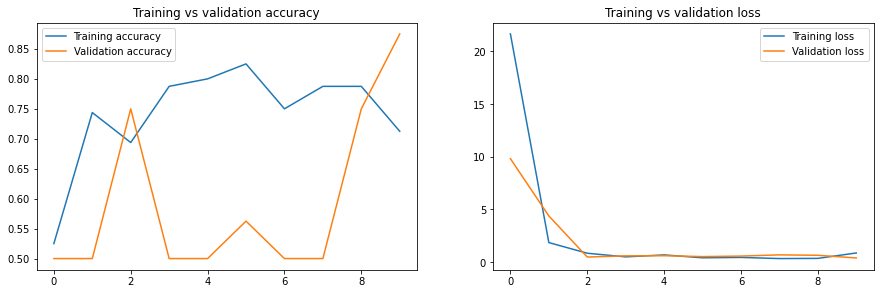

In [19]:
''' Training Accuracy and Validaion Accuracy graph '''
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()